# DEPRECATED - NO LONGER UP TO DATE. Use with caution if at all...

# Preliminary Plots with Annular Accretion Disk

## Summer 2019 Caltech Research

Started on 21 June 2019. This notebook will serve as a compilation of useful functions and tools that will serve me thoughout this project.

### Imports

In [16]:
import numpy as np
from scipy.optimize import minimize
import astropy.io.fits as fits
import matplotlib.pyplot as plt

### Constants (astronomy is in cgs, right?)

In [17]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16

## Temperature profile of a Keplerian disk

In the limit of steady accretion and being an optically thick disk, Hartmann and Kenyon (1996) provide
$$T^4 = \dfrac{3GM_* \dot{M}}{8\pi\sigma r^3}\Big[1 - \Big(\dfrac{r_i}{r}\Big)^{1/2}\Big] $$

where $R_i$ is the inner disk radius.

In [18]:
def tempKepDisk(r, r_inner, m_dot, m_star):
    term1 = 3*G*m_star*m_dot / (8 * np.pi * SIG_SB * (r**3))
    term2 = (1 - (r_inner/r)**(1/2))
    return (term1 * term2)**(1/4)

def tempKepDiskNeg(r, r_inner, m_dot, m_star):
    return -tempKepDisk(r, r_inner, m_dot, m_star)

In [19]:
def findMaxTemp(r_inner, m_dot, m_star):
    res = minimize(tempKepDiskNeg, 2*r_inner, args=(r_inner, m_dot, m_star), method='Nelder-Mead')
    return (res.x[0], -res.fun)

### Correcting the Keplerian temperature profile as done in KHH88

There is an obvious maximum temperature, $T_\text{max}$, that can be seen when plotting $T(r)$, which is unphysical, so setting all radii below $r_\text{max}$ to have that temperature is not an unreasonable first approximation.

In [20]:
def tempFUOriDisk(r, r_inner, m_dot, m_star):
    # Doesn't read in as arrays for some reason,
    # doing this element-wise...
    res = np.zeros(len(r))
    for i in range(len(r)):
        if r[i] <= findMaxTemp(r_inner, m_dot, m_star)[0]:
            res[i] = findMaxTemp(r_inner, m_dot, m_star)[1]
        else:
            res[i] = tempKepDisk(r[i], r_inner, m_dot, m_star)
    return res

## Luminosity per wavelength of accretion disk annulus

Planck's law gives the spectral radiance, so just multiply by the emitting surface area to get the luminosity per wavelength:
$$L_\lambda = 2\pi(r_b^2 - r_a^2)\dfrac{2hc^2}{\lambda^5}\dfrac{1}{\exp(\frac{hc}{\lambda k_B T}) - 1}$$

where this will be in erg/s/cm.

In [21]:
def lumWaveAnnulus(wavelength, temp, r_b, r_a):
    term1 = 2*np.pi *(r_b**2 - r_a**2)
    term2 = 2*h_PLANCK*(c_LIGHT**2)*(wavelength**(-5))
    term3 = (np.exp(h_PLANCK*c_LIGHT/(wavelength*k_BOLTZ*temp))-1)**(-1)
    return term1*term2*term3

## Luminosity per frequency of accretion disk annulus

Planck's law gives the spectral radiance, so just multiply by the emitting surface area to get the luminosity per frequency:
$$L_\nu = 2\pi(r_b^2 - r_a^2)\dfrac{2h \nu^3}{c^2}\dfrac{1}{\exp(\frac{h\nu}{k_B T}) - 1}$$

In [22]:
def lumFreqAnnulus(freq, temp, r_b, r_a):
    term1 = 2*np.pi *(r_b**2 - r_a**2)
    term2 = 2*h_PLANCK*(c_LIGHT**(-2))*(freq**3)
    term3 = (np.exp(h_PLANCK*freq/(k_BOLTZ*temp))-1)**(-1)
    return term1*term2*term3

## Luminosity of accretion disk by summing annuli

Now, I obtain my temperature at an annulus at radius $r$ using:
$$T^4 = \dfrac{3GM_* \dot{M}}{8\pi\sigma r^3}\Big[1 - \Big(\dfrac{r_i}{r}\Big)^{1/2}\Big] $$
and then calculate the luminosity of that annulus using:
$$L_\nu = A_\text{annulus}\dfrac{2h \nu^3}{c^2}\dfrac{1}{\exp(\frac{h\nu}{k_B T}) - 1}$$
However, I need to make sure that I use 
$$A_\text{annulus} = 2\pi(r_b^2 - r_a^2)$$
where I will supply tuples of $(r_a, r_b)$, with the difference between the two increasing at farther distances from the center, and I will use the temperature at $r_\text{avg} \equiv (r_b - r_a)/2$.

## Test Values used throughout

In [23]:
# Setting some test values
r_star_test = 6 * R_SUN

r_inner_test_new = 1.0 * r_star_test

r_low_test = 1.0*r_star_test
r_high_test = 30*r_star_test
r_sep_test = 0.5 * r_star_test

m_dot_test = 2.5 * 1e-4 * M_SUN / 3.154e7
m_star_test = 0.6 * M_SUN


# Evenly spaced distances for now
r_list_test = np.arange(r_low_test, r_high_test, r_sep_test)

In [24]:
r_tup_test = []
for i in range(len(r_list_test)-1):
    r_tup_test.append((r_list_test[i], r_list_test[i+1]))

These are my tuples of radii

In [25]:
r_tup_test = np.array(r_tup_test)

r_b_test = np.array([i[1] for i in r_tup_test])
r_a_test = np.array([i[0] for i in r_tup_test])

Now, to find the $r_\text{avg}$ and corresponding temperatures:

In [26]:
r_avg_test = np.mean(r_tup_test, axis=1)
temps_kep_test = tempKepDisk(r_avg_test, r_inner_test_new, m_dot_test, m_star_test)
temps_test = tempFUOriDisk(r_avg_test, r_inner_test_new, m_dot_test, m_star_test)

Now, to plot those temperatures for a sanity check:

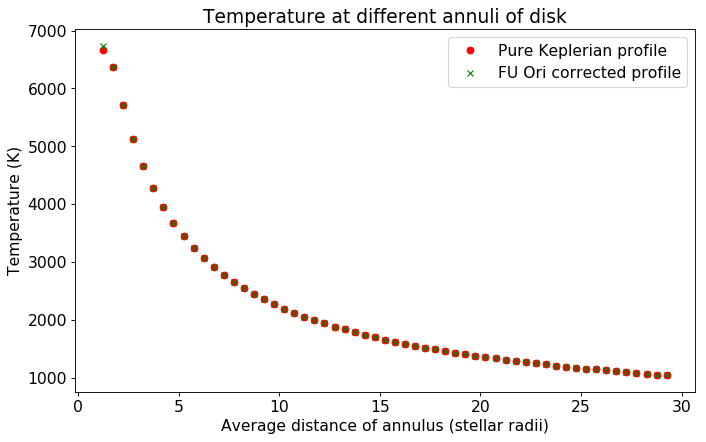

In [27]:
fig=plt.figure(figsize=(10, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(r_avg_test/r_star_test, temps_kep_test, 'ro', label='Pure Keplerian profile')
plt.plot(r_avg_test/r_star_test, temps_test, 'gx', label='FU Ori corrected profile')

plt.xlabel('Average distance of annulus (stellar radii)')
# plt.xticks(ticks, np.array(ticks, dtype=str))
plt.ylabel('Temperature (K)')
plt.title('Temperature at different annuli of disk')
plt.legend()
plt.show()

In [28]:
# Remember that we're in cgs units!!
f_start = c_LIGHT/ (7000e-8)
f_end = c_LIGHT/ (4000e-8)

Plotting

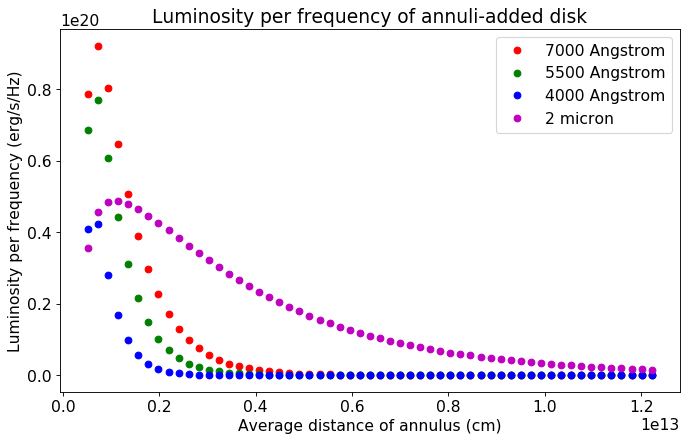

In [29]:
fig=plt.figure(figsize=(10, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(r_avg_test, lumFreqAnnulus(f_start, temps_test, r_b_test, r_a_test), 'ro', label='7000 Angstrom')
plt.plot(r_avg_test, lumFreqAnnulus(c_LIGHT/ (5500e-8), temps_test, r_b_test, r_a_test), 'go',\
                                                                             label='5500 Angstrom')
plt.plot(r_avg_test, lumFreqAnnulus(f_end, temps_test, r_b_test, r_a_test), 'bo', label='4000 Angstrom')
plt.plot(r_avg_test, lumFreqAnnulus(c_LIGHT/ (20000e-8), temps_test, r_b_test, r_a_test), 'mo', \
                                                                             label='2 micron')


plt.xlabel('Average distance of annulus (cm)')
# plt.xticks(ticks, np.array(ticks, dtype=str))
plt.ylabel('Luminosity per frequency (erg/s/Hz)')
plt.title('Luminosity per frequency of annuli-added disk')
plt.legend()
plt.show()

## Incorporating Values from Table 3 in KHH1988

Let's see how the values from that table compare...

In [30]:
khh_rad = np.array([1.5, 1.73, 1.95, 2.14, 2.26, 2.37,\
                   2.55, 2.77, 2.98, 3.20, 3.85, 4.60,\
                   4.86, 5.19, 5.70, 6.28, 6.96, 7.77,\
                   8.73, 9.91, 11.37, 13.22, 15.64,\
                   18.89, 23.46, 28.16, 32.35, 37.74,\
                   44.86, 54.64, 68.77, 90.64, 128.19,\
                   204.84, 429.26])
khh_temp = np.array([6590, 6370, 6150, 5800, 5650,\
                    5500, 5370, 5100, 4900, 4700,\
                    4500, 3750, 3600, 3500, 3300,\
                    3100, 2900, 2700, 2500, 2300,\
                    2100, 1900, 1700, 1500, 1300,\
                    1100, 1000, 900, 800, 700, 600,\
                    500, 400, 300, 200])

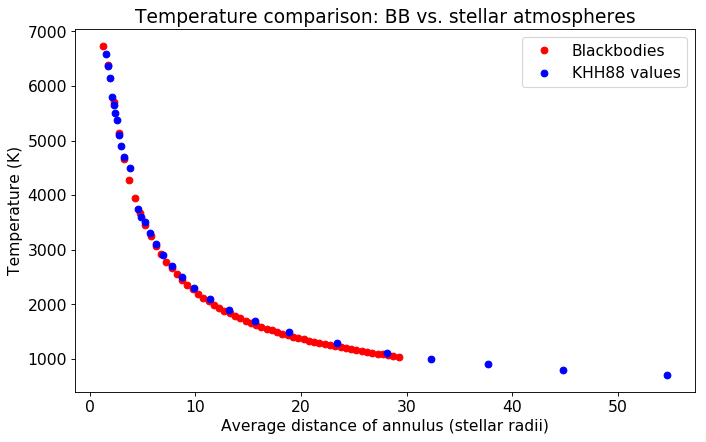

In [31]:
fig=plt.figure(figsize=(10, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(r_avg_test/r_star_test, temps_test, 'ro', label='Blackbodies')
plt.plot(khh_rad[:30], khh_temp[:30], 'bo', label='KHH88 values')
plt.xlabel('Average distance of annulus (stellar radii)')
# plt.xticks(ticks, np.array(ticks, dtype=str))
plt.ylabel('Temperature (K)')
plt.title('Temperature comparison: BB vs. stellar atmospheres')
plt.legend()
plt.show()

This is going to be rough... scroll down quite a bit for the rest.

In [32]:
col1 = np.array([0.63,
0.12,
0.13,
0.04,
0.02,
0.02,
0.03,
0.01,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.])

In [33]:
col2 = np.array([0.40,
0.12,
0.19,
0.07,
0.04,
0.02,
0.04,
0.03,
0.01,
0.01,
0.03,
0.01,
0.01,
0.01,
0.01,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.])

In [34]:
col3 = np.array([0.31,
0.15,
0.14,
0.09,
0.04,
0.03,
0.04,
0.04,
0.02,
0.02,
0.06,
0.03,
0.01,
0.01,
0.01,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0])

In [35]:
col4 = np.array([0.21,
0.14,
0.12,
0.09,
0.04,
0.04,
0.05,
0.05,
0.03,
0.03,
0.07,
0.05,
0.01,
0.02,
0.02,
0.01,
0.01,
0.01,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.])

In [36]:
col5 = np.array([0.16,
0.12,
0.10,
0.09,
0.04,
0.04,
0.05,
0.05,
0.04,
0.03,
0.08,
0.07,
0.02,
0.02,
0.02,
0.02,
0.02,
0.01,
0.01,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.])

In [37]:
col6 = np.array([0.13,
0.11,
0.09,
0.08,
0.04,
0.04,
0.04,
0.04,
0.03,
0.03,
0.08,
0.08,
0.02,
0.03,
0.03,
0.03,
0.03,
0.02,
0.02,
0.01,
0.01,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.])

In [38]:
col7 = np.array([0.12,
0.08 ,
0.07 ,
0.06 ,
0.03 ,
0.03,
0.04 ,
0.04 ,
0.03 ,
0.03 ,
0.08 ,
0.10 ,
0.03 ,
0.04 ,
0.04 ,
0.04 ,
0.03 ,
0.03 ,
0.02 ,
0.02 ,
0.01 ,
0.01 ,
0.01 ,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.])

In [39]:
col8 = np.array([0.08,
0.05,
0.05,
0.04,
0.02,
0.02,
0.03,
0.03,
0.02,
0.03,
0.07,
0.11,
0.03,
0.04,
0.05,
0.05,
0.05,
0.04,
0.04,
0.04,
0.03,
0.03,
0.02,
0.01,
0.01,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.,
0.])

In [40]:
col9 = np.array([0.03,
0.02,
0.02,
0.02,
0.01,
0.01,
0.01,
0.02,
0.01,
0.01,
0.04,
0.08,
0.03,
0.04,
0.04,
0.04,
0.04,
0.05,
0.05,
0.06,
0.06,
0.06,
0.06,
0.06,
0.05,
0.03,
0.01,
0.01,
0.01,
0.,
0.,
0.,
0.,
0.,
0.])

In [41]:
col10 = np.array([0.02,
0.01,
0.01,
0.01,
0.01,
0.01,
0.01,
0.01,
0.01,
0.01,
0.02,
0.05,
0.02,
0.02,
0.02,
0.03,
0.03,
0.03,
0.04,
0.05,
0.05,
0.06,
0.07,
0.08,
0.08,
0.06,
0.04,
0.04,
0.03,
0.03,
0.02,
0.01,
0.,
0.,
0.])

In [42]:
col11 = np.array([0.08,
0.05,
0.05,
0.04,
0.02,
0.02,
0.03,
0.03,
0.03,
0.03,
0.07,
0.06,
0.02,
0.02,
0.03,
0.03,
0.03,
0.03,
0.03,
0.03,
0.03,
0.03,
0.02,
0.02,
0.02,
0.02,
0.01,
0.01,
0.01,
0.01,
0.01,
0.01,
0.01,
0.01,
0.01])

In [43]:
khh_arr_draft = np.array([col1, col2, col3, col4, col5, col6, col7, col8, col9, col9,col10, col11])

Finally, here are the fractional fluxes from the KHH88 paper!

In [44]:
khh_fluxes = np.transpose(khh_arr_draft)

### Finding a way to plot this now...

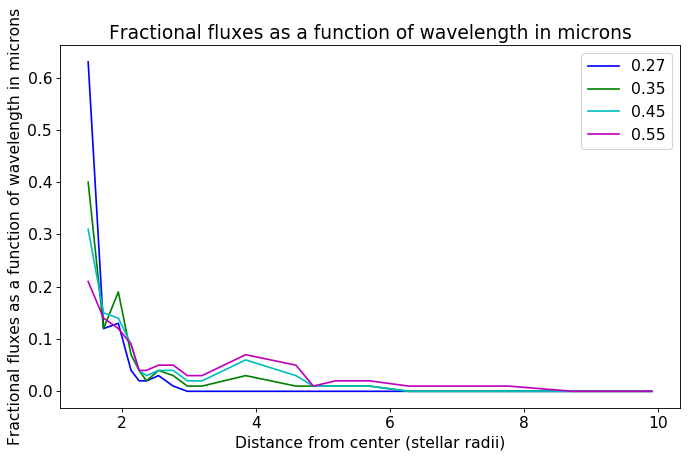

In [45]:
fig=plt.figure(figsize=(10, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(khh_rad[:20], khh_fluxes[:,0][:20], 'b-', label='0.27')
plt.plot(khh_rad[:20], khh_fluxes[:,1][:20], 'g-', label='0.35')
plt.plot(khh_rad[:20], khh_fluxes[:,2][:20], 'c-', label='0.45')
plt.plot(khh_rad[:20], khh_fluxes[:,3][:20], 'm-', label='0.55')

plt.ylabel('Fractional fluxes as a function of wavelength in microns')
plt.xlabel('Distance from center (stellar radii)')
plt.title('Fractional fluxes as a function of wavelength in microns')
plt.legend()
plt.show()

### Comparing KHH88 values to luminosity plot I had above

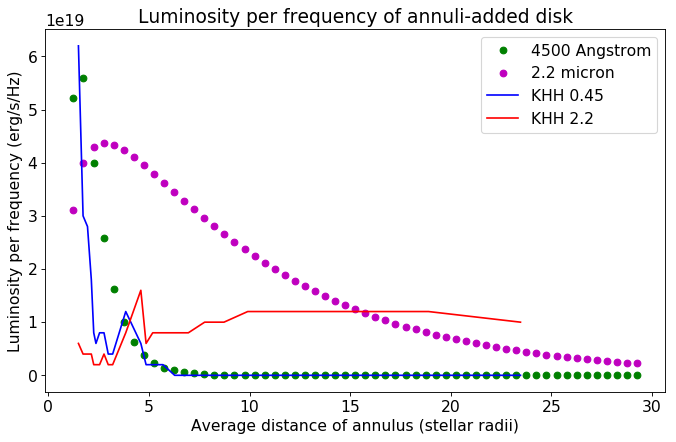

In [46]:
fig=plt.figure(figsize=(10, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(r_avg_test/r_star_test, lumFreqAnnulus(c_LIGHT/ (4500e-8), temps_test, r_b_test, r_a_test), 'go', label='4500 Angstrom')

plt.plot(r_avg_test/r_star_test, lumFreqAnnulus(c_LIGHT/ (22000e-8), temps_test, r_b_test, r_a_test), 'mo', \
                                                                             label='2.2 micron')
plt.plot(khh_rad[:25], khh_fluxes[:,2][:25]*2e20, 'b-', label='KHH 0.45')
plt.plot(khh_rad[:25], khh_fluxes[:,8][:25]*2e20, 'r-', label='KHH 2.2')



plt.xlabel('Average distance of annulus (stellar radii)')
# plt.xticks(ticks, np.array(ticks, dtype=str))
plt.ylabel('Luminosity per frequency (erg/s/Hz)')
plt.title('Luminosity per frequency of annuli-added disk')
plt.legend()
plt.show()

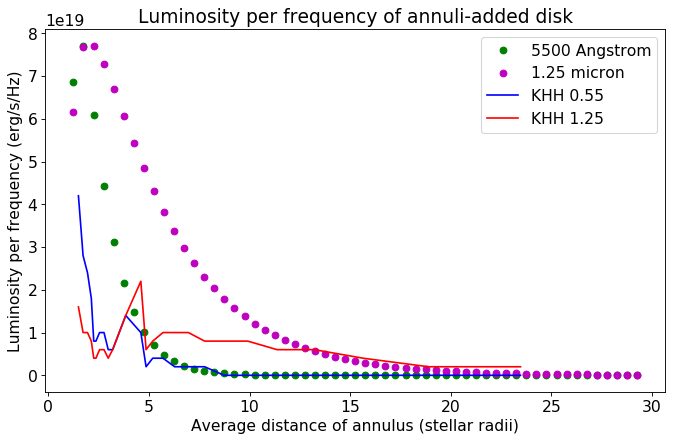

In [47]:
fig=plt.figure(figsize=(10, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(r_avg_test/r_star_test, lumFreqAnnulus(c_LIGHT/ (5500e-8), temps_test, r_b_test, r_a_test), 'go',\
                                                                                     label='5500 Angstrom')

plt.plot(r_avg_test/r_star_test, lumFreqAnnulus(c_LIGHT/ (12500e-8), temps_test, r_b_test, r_a_test), 'mo', \
                                                                                     label='1.25 micron')
plt.plot(khh_rad[:25], khh_fluxes[:,3][:25]*2e20, 'b-', label='KHH 0.55')
plt.plot(khh_rad[:25], khh_fluxes[:,7][:25]*2e20, 'r-', label='KHH 1.25')



plt.xlabel('Average distance of annulus (stellar radii)')
# plt.xticks(ticks, np.array(ticks, dtype=str))
plt.ylabel('Luminosity per frequency (erg/s/Hz)')
plt.title('Luminosity per frequency of annuli-added disk')
plt.legend()
plt.show()

## Generating a model spectrum

This routine sums up the contribution of different annuli and outputs luminosity per wavelength as a function of wavelength.

Helper function to generate arrays of distances to different annuli:

In [48]:
def generateDistArrays(r_inner, r_outer, r_sep):
    r_list = np.arange(r_inner, r_outer, r_sep)
    r_tup = []
    for i in range(len(r_list)-1):
        r_tup.append((r_list[i], r_list[i+1]))
    r_tup = np.array(r_tup)
    r_b = np.array([i[1] for i in r_tup])
    r_a = np.array([i[0] for i in r_tup])
    r_avg = np.mean(r_tup, axis=1)
    return (r_tup, r_avg, r_a, r_b)

In [49]:
def generateModelSpectrum(r_star, r_inner, r_outer, r_sep, m_star, m_dot, wave_lower, wave_upper):
    r_tup, r_avg, r_a, r_b = generateDistArrays(r_inner, r_outer, r_sep)
    waves = np.linspace(wave_lower, wave_upper, 100)
    temp = tempFUOriDisk([r_avg[0]], r_inner, m_dot, m_star)
    lum = lumWaveAnnulus(waves, temp, r_b[0], r_a[0])
    for i in range(1,len(r_avg)):
        temp = tempFUOriDisk([r_avg[i]], r_inner, m_dot, m_star)
        lum += lumWaveAnnulus(waves, temp, r_b[i], r_a[i])
    return (waves,lum)

In [50]:
modSpec = generateModelSpectrum(r_star_test, r_low_test, r_high_test,r_star_test,\
                      m_star_test, m_dot_test, 4000e-8, 20000e-8)

In [51]:
r_high_test/r_star_test

30.0

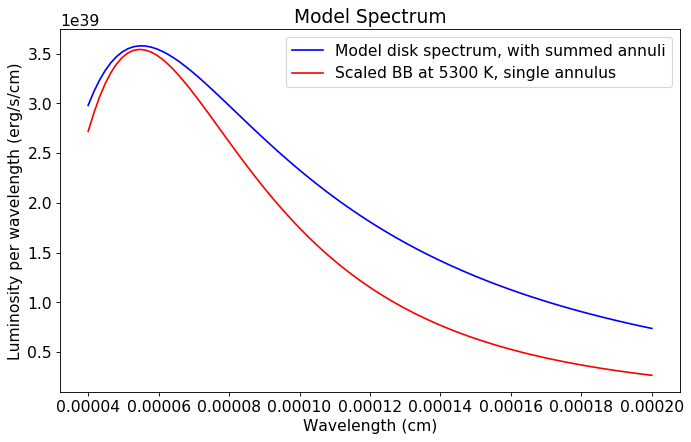

In [52]:
fig=plt.figure(figsize=(10, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(modSpec[0], modSpec[1], 'b-', label='Model disk spectrum, with summed annuli')
plt.plot(modSpec[0], 0.021*lumWaveAnnulus(modSpec[0], 5300, r_high_test, r_low_test), \
         'r-', label='Scaled BB at 5300 K, single annulus')

plt.xlabel('Wavelength (cm)')
plt.ylabel('Luminosity per wavelength (erg/s/cm)')
plt.title('Model Spectrum')
plt.legend()
plt.show()

### Testing against the fractional flux tables from KHH88

In [53]:
def generateFractions(wavelength, r_star, r_inner, r_outer, r_sep, m_star, m_dot):
    r_tup, r_avg, r_a, r_b = generateDistArrays(r_inner, r_outer, r_sep)
    temps = tempFUOriDisk(r_avg, r_inner, m_dot, m_star)
    lums = lumWaveAnnulus(wavelength, temps, r_b, r_a)
    
    tot = np.sum(lums)
    fracs = lums/tot
    return (temps, fracs)

In [54]:
# Setting some test values
r_star_test = 6 * R_SUN

r_inner_test_new = 1. * r_star_test

r_low_test = 1.*r_star_test
r_high_test = 430*r_star_test
r_sep_test = 0.5 * r_star_test

m_dot_test = 2.5 * 1e-4 * M_SUN / 3.154e7
m_star_test = 0.6 * M_SUN


fracs = generateFractions(4000e-8, r_star_test, r_low_test, r_high_test, r_star_test,\
                      m_star_test, m_dot_test)


fracs1 = generateFractions(3500e-8, r_star_test, r_low_test, r_high_test, r_star_test*0.6,\
                      m_star_test, m_dot_test)
fracs2 = generateFractions(6400e-8, r_star_test, r_low_test, r_high_test, r_star_test*0.6,\
                      m_star_test, m_dot_test)
fracs3 = generateFractions(12500e-8, r_star_test, r_low_test, r_high_test, r_star_test*0.6,\
                      m_star_test, m_dot_test)

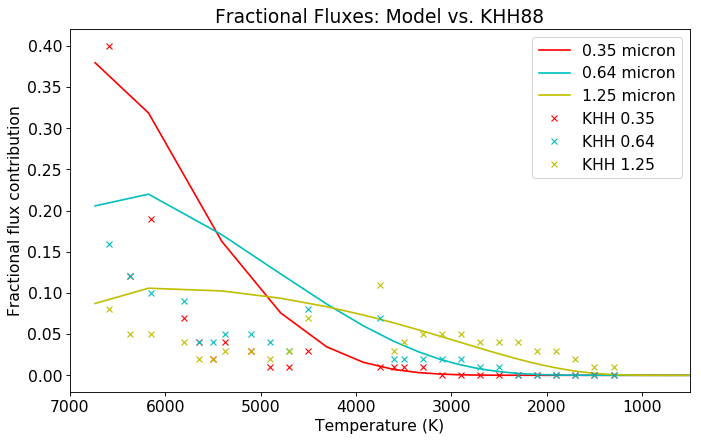

In [55]:
fig=plt.figure(figsize=(10, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(fracs1[0], fracs1[1], 'r-', label='0.35 micron')
plt.plot(fracs2[0], fracs2[1], 'c-', label='0.64 micron')
plt.plot(fracs3[0], fracs3[1], 'y-', label='1.25 micron')

plt.plot(khh_temp[:25], khh_fluxes[:,1][:25], 'rx', label='KHH 0.35')
plt.plot(khh_temp[:25], khh_fluxes[:,4][:25], 'cx', label='KHH 0.64')
plt.plot(khh_temp[:25], khh_fluxes[:,7][:25], 'yx', label='KHH 1.25')

plt.title('Fractional Fluxes: Model vs. KHH88')
plt.xlim(7000,500)
plt.xlabel('Temperature (K)')
plt.ylabel('Fractional flux contribution')
plt.legend()
plt.show()